#### **Basic instructions:**
#### 1. **To run code cells**, you can either hit the play button to the left of the cell, or you can select the cell and **press shift-enter**.

#### 2. **The first time** you run this code notebook, you might get a popup asking to choose which version of Python to use (the python "kernel"). **Just hit enter** to choose the base/default version.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files over from where they are saved on your computer.

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

# Ca channels: inactivation

## 1. Choose the data file you want to analyze

#### Put the .abf files with your Ca channel recordings in the "data/Ca_channels" folder

In [5]:
data_folder = "data/Ca_channels"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/Ca_channels


['data/Ca_channels/CAV_Lomb(Peak)_22831005.abf',
 'data/Ca_channels/CAV_Tho_IV.abf',
 'data/Ca_channels/2024_06_10_0027.abf',
 'data/Ca_channels/CAV_Lomb(Cd)_22831010.abf',
 'data/Ca_channels/CAV_Lomb_IV.abf']

Choose which file you want to analyze and past the file name here:

In [29]:
data_file = 'data/Ca_channels/CAV_Tho_IV.abf'

Now we can load the file and plot the raw data:

Data dimensions (sweeps, channels, timepoints): 
(32, 2, 13750)
sampling freq: 49999.99999999999 Hz


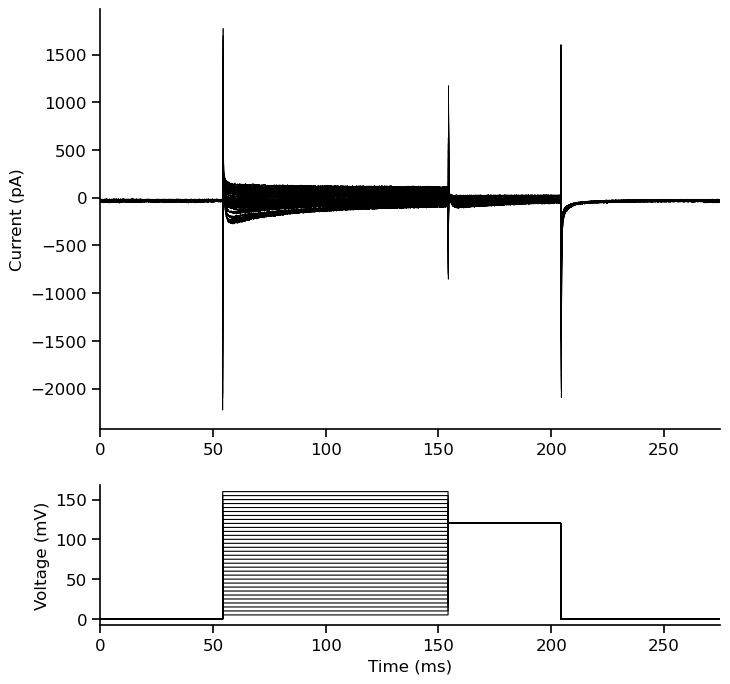

In [30]:
## Extract the sweeps, time and sampling frequency:
sweeps, sweeps_time, sampling_freq = get_sweeps(data_file)

print(f"Data dimensions (sweeps, channels, timepoints): \n{sweeps.shape}")
print(f"sampling freq: {sampling_freq} Hz")

current_traces = sweeps[:, 0, :]
voltage_traces = sweeps[:, 1, :]
ax = plot_traces(sweeps_time*1000, current_traces, voltage_traces)
plt.show()

## 2. Select what you want to measure

### 2.1. Defining the time window

First let's define the relevant time window where we want to measure the currents:

(If you want to save the images, you can do it by clicking on the save icon in the top-right of the image when you hover over it)

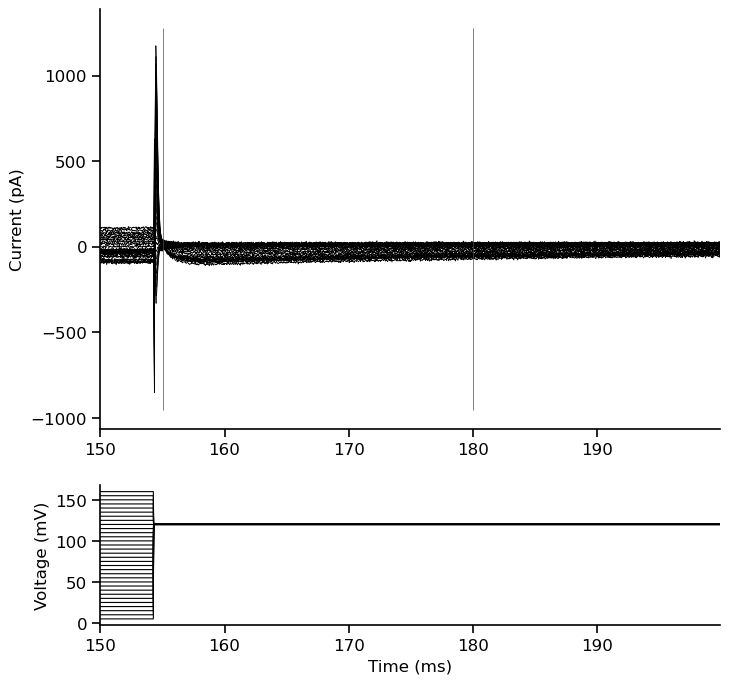

In [31]:
# The start/end time just helps to zoom in on the traces.
start_time = 150  # milliseconds
end_time = 200   # milliseconds, (enter -1 to get the end of the sweep)

# The markers are important: the will define the window where we actually exctract peak current values from. Set them carefully.
marker_1 = 155  # milliseconds
marker_2 = 180    # milliseconds

current_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=0)
voltage_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=1)

ax = plot_traces(time_in_window, current_traces, voltage_traces, marker_1, marker_2)
plt.show()

### 3.1. Optional: apply baseline correction

If your baseline current is not zero, you may need to correct for that to get accurate measurements.

Uncomment this cell block (highlight everything, then cmd+/ on macOS or ctrl+/ on Windows) to run it.

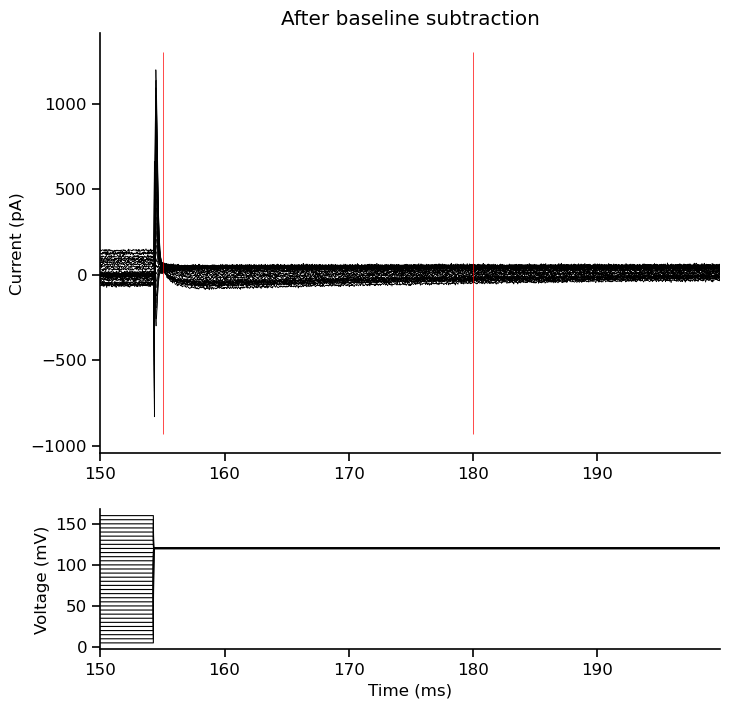

In [32]:
# Change this to True if you want to subtract the baseline from the sweeps.
subtract_baseline = True

# Measure baseline: you need to specify which part of the trace you want to use for baseline measurement.
start_baseline = 0 # milliseconds
end_baseline = 1 # milliseconds
measurement_type = 'mean' # Options: 'mean', 'max', 'min'


# --------------------------------------------------------------------------------------------------------------------
if subtract_baseline:
    baseline_voltage, baseline_current = get_step_measurements(sweeps, sweeps_time, start_baseline, end_baseline, sampling_freq, measurement_type)

    # Subtract baseline from the sweeps
    num_traces = sweeps.shape[0]
    for i in range(num_traces):
        sweeps[i,0] -= baseline_current[i]

    current_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=0)
    voltage_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=1)
    ax = plot_traces(time_in_window, current_traces, voltage_traces, marker_1, marker_2)
    ax[0].set_title('After baseline subtraction')
    plt.show()

### 3.2. Measure currents

Here we will be using the timepoints from the markers we defined above.

First we want to measure the holding voltages from the first phase of the step protocol:


In [ ]:
# Define the timepoint where the voltage is measured
voltage_timepoint = 150 
channel = 1
voltage_steps = sweeps[:, channel, time_to_index(voltage_timepoint, sampling_freq)]

Now we can actually measure the currents and normalized againts the max current.

Boltzmann Fit parameters:
V_half: 30.563, k: -3.393


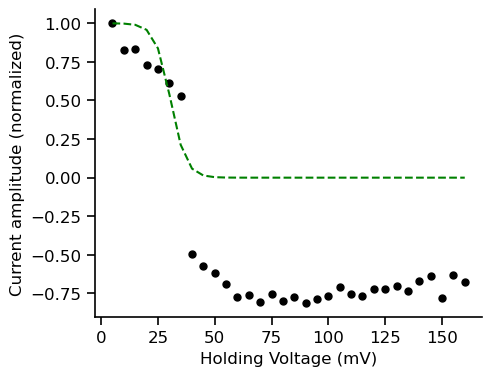

In [ ]:
measurement_type = 'peak' # Options: 'mean', 'max', 'min', 'peak'

_, current_steps = get_step_measurements(sweeps, sweeps_time, 
                                        start_time=marker_1,
                                        end_time=marker_2,
                                        sampling_freq=sampling_freq,
                                        measurement_type=measurement_type)
# # # Remove bad sweeps
# current_steps = current_steps[13:]
# voltage_steps = voltage_steps[13:]

# Normalize to the biggest current
current_steps = current_steps / np.min(current_steps)  # Normalize current steps to the minimum value

# Plot the normalized current steps against the holding voltages
# plt.figure(figsize=(5, 4))
fig,ax = plt.subplots(figsize=(5, 4))
ax.plot(voltage_steps, current_steps, 'o', color='black', markersize=5)
ax.set_xlabel('Holding Voltage (mV)')
ax.set_ylabel('Current amplitude (normalized)')

# Optional: fit a Boltzmann function (sigmoid curve) to the data
from scipy.optimize import curve_fit
def boltzmann(V, V_half, k):
    return 1 / (1 + np.exp((V_half - V) / k))
k_guess = -5 # Initial guess for the slope parameter
popt, _ = curve_fit(boltzmann, voltage_steps, current_steps, p0=[np.median(voltage_steps), k_guess])
ax.plot(voltage_steps, boltzmann(voltage_steps, *popt), linestyle='--', color='g', label='Fit')
print("Boltzmann Fit parameters:")
print(f"V_half: {popt[0]:.3f}, k: {popt[1]:.3f}")
plt.show()